# Assignment 02 - Transforms

This assignment covers robustness testing using data transforms with PyTorch and TorchVision.

## Introduction

As we have seen in class, PyTorch and its related packaged provide a powerful means of transforming data in a way that is decoupled from the actual code in our training loop.

The `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes provide an interface for us to quickly download standard ML datasets and to make our our datasets which can benefit from the full functionality of PyTorch and its related packages.

When combined with `torch.transforms`, these tools provide a means to transform our data, and to change which transforms we apply without having to make changes to our core training code. This is incredibly useful for data augmentation, domain generalization, and robustness testing.

For data augmentation, transforms can be applied before training to help us increase the diversity in our dataset, and instill expert knowledge into our models by having experts select which transforms we apply to the training data (e.g., applying rotations to a model which must be perspective invariant).

For domain generalization, transforms can be applied during training to help us improve our model's ability to generalize to new domains (environments in which the model must perform its task). For example, varying the color of the background randomly ensures the model is not incorrectly sensitive to background color and will not break in a domain with different background colors.

For robustness testing, transforms can be applied after training to assess our model's robustness to challenging factors in our data, e.g., blur, color changes, perspective changes, and other variations. We can apply transforms to various degrees using the parameters that PyTorch exposes to adjust the transform. This enables us to extract performance curves for our models which go beyond simply displaying a confusion matrix as the output of model training.

This assignment will focus on applying transforms for robustness testing.

## Directions

In this assignment, we will train a model and assess its robustness using PyTorch. To do this, we will carry out the following steps.

1. **Load Data**: This step will require us to import a torch Dataset and use a torch DataLoader to access it. You may use any dataset you like, as long as it is imagery (since this assignment is focused on image transforms). Datasets built into PyTorch may be used. **0.25 points extra credit will be awarded for implementing a custom Dataset.** Be sure to pick a dataset you have the capacity to train a model on in your development environment. To keep the assignment fair grading will not be based on the size of the dataset used in any way. Plot a few of the images to ensure you have loaded the data correctly.

2. **Define the Training Pipeline**: This step will require us to define the class which specifies our neural network architecture, and to define the functions which allow us to train it. We have seen examples of this before, both in class and prior assignments. Be sure to chose an architecture with sufficient capacity to learn the dataset you have chosen in step #1.

3. **Train the Model**: In this step we will use our training functions from step #2 to train a model.

4. **Use Transforms to Robustness Test the Model Against Blur**: In this step, we will robustness test the model against an image blur transform. This step will require us to run model inference on the **test** set repeatedly, increasing the amount of image blur with each run. For each image blur level, we will need to save off the accuracy, then plot the accuracy against the degree of blur (choose and appropriate metric for the degree of blur). The end result of this step should be a plot of accuracy with respect to degree of blur. Be sure to test the model **to failure** to fully characterize its limitations.

5. **Robustness Test the Model Against a Transform of Your Choice**: In this step, we will robustness test the model against a transform of our choice (perhaps perspective changes, color changes, or contrast changes). Like step #4, this step will require us to run model inference on the **test** set repeatedly

## Grading

This assignment is entirely open ended and will not be auto-graded. Each step is worth 20% of the assignment grade. For each step, ensure the following conditions are met to get full credit.

| **Step** | **Criteria for Full Credit** |
|----|----|
| 1. Data Loading |  The data is successfully loaded and a few of the images are visualized.  |
| 2. Training Pipeline Definition | The training pipeline and neural network architecture are defined and error free.  |
| 3. Training | The model training runs for a sufficient number of epochs and the error curve is negative, indicating some learning is taking place. |
| 4. Robustness Test - Blur  | A curve of accuracy with respect to degree of blur is produced and is of professional quality. |
| 5. Robustness Test - Other  | A curve of accuracy with respect to degree of transformation is produced and is of professional quality. |

## Tips

This assignment is intentionally open ended. **No starter code is provided.** The goal of this assignment is to test your ability to put the concepts we have discussed in class into practice.

The steps should be similar, but not necessarily exactly the same, as steps we have discussed in class.

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1 - Load Data

Use the cell below (or make additional cells) to load a torch Dataset and use a torch DataLoader to access it. You may use any dataset you like, as long as it is imagery (since this assignment is focused on image transforms). Datasets built into PyTorch may be used.

**0.25 points extra credit will be awarded for implementing a custom Dataset.** Be sure to pick a dataset you have the capacity to train a model on in your development environment. To keep the assignment fair grading will not be based on the size of the dataset used in any way. Plot a few of the images to ensure you have loaded the data correctly.


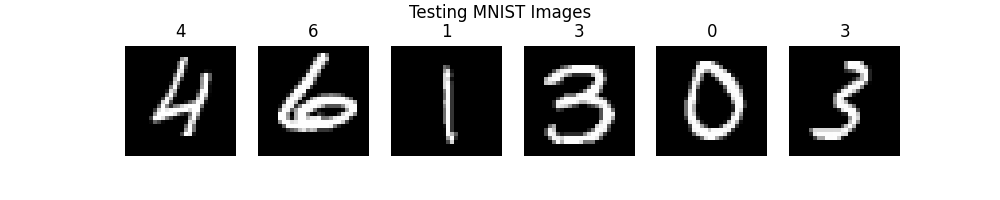

In [23]:
train_transform = transforms.Compose([
    transforms.ToTensor(),  
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST(root="data", train=True, download=True, transform=train_transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

iterator = iter(train_loader)
data, label = next(iterator)

fig, axes = plt.subplots(1, 6, figsize=(10, 2))
for i in range(6):
    axes[i].imshow(data[i][0], cmap='gray')
    axes[i].set_title(f"{label[i].item()}")
    axes[i].axis('off')
plt.suptitle("Testing MNIST Images")
plt.show()

## Step 2 - Define Training Pipeline

Define a training pipeline like those we have seen in class. Define the class which specifies our neural network architecture, and to define the functions which allow us to train it. We have seen examples of this before, both in class and prior assignments.

Be sure to chose an architecture with sufficient capacity to learn the dataset you have chosen in step #1.

Tip: if you see your architecture is insufficient to learn the dataset you have chosen when you run step 3, you may need to return to step #2 to make your architecture wider or deeper.

In [ ]:
@dataclass
class TrainingParameters:
    """Training parameters for a simple neural network trainer."""

    batch_size: int = 64
    test_batch_size: int = 1000
    epochs: int = 14
    lr: float = 1.0
    gamma: float = 0.7
    normalizer_mean = 0.1307
    normalizer_std = 0.3081
    no_cuda: bool = True  # Enable or disable CUDA
    no_mps: bool = True  # Enable or disable GPU on MacOS
    dry_run: bool = False
    seed: int = 1
    log_interval: int = 10
    save_model: bool = True


def configure_training_device(training_params):
    use_cuda = not training_params.no_cuda and torch.cuda.is_available()
    use_mps = not training_params.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(training_params.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {"batch_size": training_params.batch_size}
    test_kwargs = {"batch_size": training_params.test_batch_size}

    if use_cuda:
        cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    return device, train_kwargs, test_kwargs

training_params = TrainingParameters()
device, train_kwargs, test_kwargs = configure_training_device(training_params)


class Net(nn.Module):
    def __init__(self, hidden_size=128):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(28 * 28, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.input_layer(x))
        x = self.output_layer(x)
        return F.log_softmax(x, dim=1)


def run_training_epoch(
    training_params, model, device, train_loader, optimizer, epoch
):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % training_params.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if training_params.dry_run:
                break


def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100.0 * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {acc:.2f}%\n")
    return acc

## Step 3 - Train a Model

Kick off your training run here. Be sure to print or plot the error wrt. number of epochs so you can see if your model is learning.


In [ ]:
def build_preprocessing_transform(training_params):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (training_params.normalizer_mean,),
                (training_params.normalizer_std,),
            ),
        ]
    )
    return transform


def build_data_loaders(train_kwargs, test_kwargs, transform):
    dataset1 = datasets.MNIST(
        "../data", train=True, download=True, transform=transform
    )
    dataset2 = datasets.MNIST("../data", train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    return train_loader, test_loader


def train(training_params, device, train_loader, test_loader):
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

    for epoch in range(1, training_params.epochs + 1):
        run_training_epoch(
            training_params, model, device, train_loader, optimizer, epoch
        )
        predict(model, device, test_loader)
        scheduler.step()

        if training_params.save_model:
            torch.save(model.state_dict(), "mnist_cnn.pt")

def execute_training_pipeline():
    training_params = TrainingParameters(epochs=1, dry_run=True)
    device, train_kwargs, test_kwargs = configure_training_device(
        training_params
    )
    transform = build_preprocessing_transform(training_params)
    train_loader, test_loader = build_data_loaders(
        train_kwargs, test_kwargs, transform
    )
    train(training_params, device, train_loader, test_loader)

execute_training_pipeline()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316141

Test set: Average loss: 1.9754, Accuracy: 33.38%



## Step 4 - Use Transforms to Robustness Test the Model Against Image Blur

Use the cell below (or add more cells), to write code which repeatedly (e.g., in a for-loop) infers your model on your test set. Each time you do so, apply a blur transform with an increasing amount of blur. Compute and save the average accuracy across the entire test set and then plot the accuracy against the degree of blur (choose and appropriate metric for the degree of blur). The end result of this step should be a plot of accuracy with respect to degree of blur. Be sure to test the model **to failure** to fully characterize its limitations.



Test set: Average loss: 2.1937, Accuracy: 21.76%

Blur sigma=1: Accuracy=21.76%

Test set: Average loss: 2.1956, Accuracy: 21.14%

Blur sigma=2: Accuracy=21.14%

Test set: Average loss: 2.1959, Accuracy: 20.95%

Blur sigma=3: Accuracy=20.95%

Test set: Average loss: 2.1961, Accuracy: 20.91%

Blur sigma=4: Accuracy=20.91%

Test set: Average loss: 2.1961, Accuracy: 20.88%

Blur sigma=5: Accuracy=20.88%


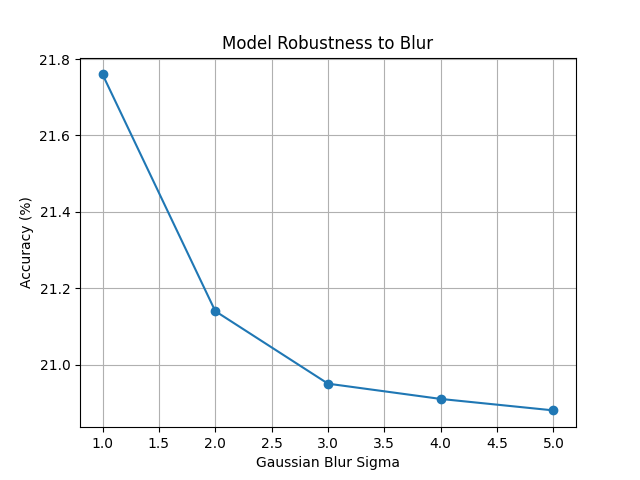

In [21]:
model = Net().to(device)
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

blur_levels = [1, 2, 3, 4, 5]
accuracies_blur = []

for num in blur_levels:
    transform_blur = transforms.Compose([
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=num),
        transforms.ToTensor()
    ])
    test_blur = datasets.MNIST(root="data", train=False, transform=transform_blur)
    test_loader_blur = DataLoader(test_blur, batch_size=1000, shuffle=False)
    acc = predict(model, device, test_loader_blur)
    accuracies_blur.append(acc)
    print(f"Blur sigma={num}: Accuracy={acc:.2f}%")

plt.figure()
plt.plot(blur_levels, np.array(accuracies_blur), marker='o')
plt.title("Model Robustness to Blur")
plt.xlabel("Gaussian Blur Sigma")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

## Step 5 - Robustness Test the Model Against a Transform of Your Choice

Repeat step 4 for a transform of your choice. Create a plot showing how model accuracy degrades as the transform is applied more drastically.



Testing robustness to brightness...

Test set: Average loss: 2.1862, Accuracy: 25.16%

Brightness=0.2: Accuracy=25.16%

Test set: Average loss: 2.1933, Accuracy: 24.58%

Brightness=0.5: Accuracy=24.58%

Test set: Average loss: 2.2091, Accuracy: 22.98%

Brightness=1.0: Accuracy=22.98%

Test set: Average loss: 2.1995, Accuracy: 22.69%

Brightness=1.5: Accuracy=22.69%

Test set: Average loss: 2.1948, Accuracy: 22.36%

Brightness=2.0: Accuracy=22.36%


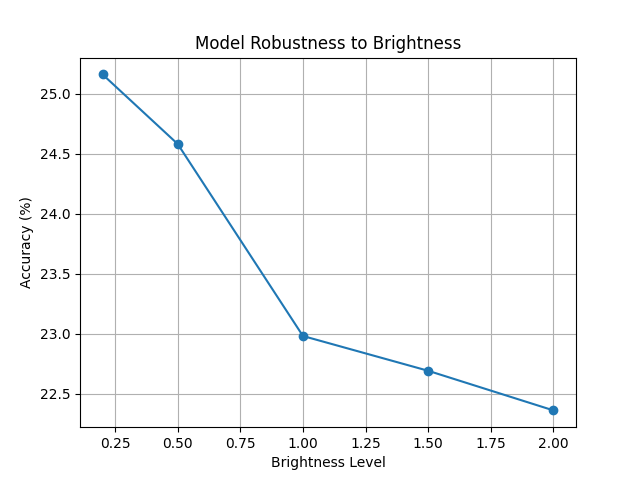

In [ ]:
brightness_levels = [0.2, 0.5, 1.0, 1.5, 2.0]
accuracies_brightness = []

for level in brightness_levels:
    transform_brightness = transforms.Compose([
        transforms.ColorJitter(brightness=level),
        transforms.ToTensor()
    ])
    test_brightness = datasets.MNIST(root="data", train=False, transform=transform_brightness)
    test_loader_brightness = DataLoader(test_brightness, batch_size=1000, shuffle=False)
    acc = predict(model, device, test_loader_brightness)
    accuracies_brightness.append(acc)
    print(f"Brightness={level}: Accuracy={acc:.2f}%")

plt.figure()
plt.plot(brightness_levels, accuracies_brightness, marker='o')
plt.title("Model Robustness to Brightness")
plt.xlabel("Brightness Level")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()